# Computational Linear Algebra: Homework 1
## Pagerank algorithm

**Academic Year:** 2025/2026

### Team Members:
1. Indiano, Giovanni (357942);
2. Stradiotti, Fabio (359415).

## 0. Introduction

At the beginning of **World Wide Web**'s development during the 1990s, complex search engines capable of filtering vast amounts of public data to deliver relevant information were needed. Early proposed solutions struggled with accuracy, frequently returning useless or irrelevant links that didn't match the user's request. The first algorithm that actually succeeded in this goal was **PageRank**, which is the primary reason behind **Google**'s enormous success. The algorithm quantitatively rates the importance of each webpage, in order to return the most helpful results first.

PageRank is a delightful application of **linear algebra**. It represents the web as a graph, in which the webpages are the vertices and the links are the edges. The intuition of the algorithm consisted in giving a certain *importance* to a page not only basing on the number of incoming links (**backlinks**), but also on the importance of the pages where these links come from. This relationship is enclosed in a matrix $A$, called the **link matrix**, where each page's importance score ($x_k$) depends on the scores of its backlinks, weighted by the number of outgoing links on those pages.

From the mathematics point of view, the ranking problem consists in finding an **eigenvector** associated with a unitary eigenvalue for a **column-stochastic matrix**. While using the algorithm, it could be possible to deal with the following problems:

- **Non-Unique Rankings**: if there are disconnected subwebs, the ranking might not be unique;
- **Dangling nodes**: pages with no outgoing links (columns of zeros in the raw link matrix $A$) make the system substochastic, causing probability mass leakage.

PageRank solves this problem by conceptually defining the **Google Matrix** $M$. To ensure stochasticity, the raw matrix $A$ is first adjusted into a stochastic matrix $\bar{A}$ by linking dangling nodes to all other pages (virtually). Then, the Google Matrix is defined as:

$$
M = (1 - m) A' + mS
$$

where $S$ is the *teleportation* matrix (rank-one matrix with entries $1/n$), and $m$ is the **teleportation probability** ($0 \le m \le 1$). In our implementation, we avoid constructing the dense matrix $M$ explicitly; instead, we compute the matrix-vector product efficiently by treating the dangling node mass redistribution and the teleportation term as vector corrections at each iteration step.

As the **Perron-Frobenius** theorem explicits, this modification ensures the resulting matrix is positive and column-stochastic and guarantees a unique, one-dimensional eigenspace with a positive eigenvector, providing a stable and unambiguous ranking for the entire web.



# Implementation of the PageRank Algorithm

In this section, we present the implementation of the PageRank algorithm. The code is structured to handle large-scale graphs efficiently using sparse matrices.

We use the **Power Iteration Method** to compute the dominant eigenvector of the Google Matrix $M$.

# Importing modules

In [11]:
import numpy as np
from scipy import sparse
from scipy.sparse import linalg as splinalg
from IPython.display import Image, display



# Damping factor used by Google
m = 0.15

### 1. Data Loading and Matrix Construction

The function `read_dat` is designed to parse the graph dataset and convert it into a column-stochastic sparse matrix $A$, which serves as the core component of the PageRank computation.

The process consists of three key steps:

1.  **Sparse Matrix Assembly:**
    To handle large-scale graphs efficiently, we avoid dense matrix representations ($O(N^2)$ memory). Instead, we construct the adjacency matrix using the **COO (Coordinate)** format, which stores only the non-zero entries (the edges).
    The matrix is constructed such that $A_{ij} = 1$ if there is a link from node $j$ to node $i$. Finally, it is converted to **CSC (Compressed Sparse Column)** format, which is optimized for column slicing and vector multiplication.

2.  **Column Normalization (Stochasticity):**
    The raw adjacency matrix contains 1s and 0s. To interpret it as a transition probability matrix, we must normalize the columns so that they sum to 1.
    The function calculates the out-degree vector $\mathbf{d}$ (column sums). For every node $j$ with outgoing links ($d_j > 0$), we scale the column:
    $$A_{ij} \leftarrow \frac{A_{ij}}{d_j}$$
    
    This is implemented efficiently using sparse matrix operations:
    $$A_{\text{norm}} = A \cdot D^{-1}$$
    where $D^{-1}$ is a diagonal matrix containing the inverse of the column sums. Nodes with no outgoing links (dangling nodes, where $d_j=0$) are explicitly handled to avoid division by zero, resulting in a zero column.

In [12]:
def read_dat(file_name):
    """
    Reads a graph from a .dat file and constructs the column-stochastic link matrix A.
    Returns:
        A (scipy.sparse.csc_matrix): The link matrix.
        labels (dict): A mapping from node ID to node name.
    """
    labels = {}
    row_indices = [] # Lists to store sparse matrix coordinates
    col_indices = []
    
    try:
        with open(file_name, 'r') as file:
            first_line = file.readline().strip()
            if not first_line:
                 return None, None
            parts = first_line.split()
            num_nodes = int(parts[0])
            num_edges = int(parts[1])
            
            # Use COO format for construction (efficient for appending)
            # Later convert to CSC (Compressed Sparse Column) for calculation
            
            for _ in range(num_nodes):
                line = file.readline().strip()
                if line:
                    parts = line.split(maxsplit=1) 
                    node_id = int(parts[0])
                    node_name = parts[1]
                    labels[node_id] = node_name

            for _ in range(num_edges):
                line = file.readline().strip()
                if line:
                    parts = line.split()
                    source = int(parts[0])
                    target = int(parts[1])
                    # Store coordinates instead of filling dense matrix directly
                    # A[target-1][source-1]=1
                    row_indices.append(target - 1)
                    col_indices.append(source - 1)
            
            # Create sparse matrix with 1s at specific coordinates
            data = np.ones(len(row_indices))
            A = sparse.coo_matrix((data, (row_indices, col_indices)), shape=(num_nodes, num_nodes)).tocsc()
            
            # Efficient column normalization for sparse matrix
            # Calculate sum of each column
            col_sums = np.array(A.sum(axis=0)).flatten()
            
            # Avoid division by zero. If sum is 0, scaling factor is 0.
            # This leaves the column as a zero vector in A, which is correct because 
            # we handle the dangling mass explicitly in the power_iteration function
            with np.errstate(divide='ignore', invalid='ignore'):
                scale_factors = np.where(col_sums != 0, 1.0 / col_sums, 0)
            
            # Multiply A by diagonal matrix of inverse sums to normalize
            D_inv = sparse.diags(scale_factors)
            A = A @ D_inv
                    
    except FileNotFoundError:
        print(f"Error: File '{file_name}' not found.")
        return None, None
    except Exception as e:
        print(f"Error during the analysis of the file: {e}")
        return None, None
    
    return A, labels

## 2. The Power Iteration Method

The objective is to compute the PageRank vector $\mathbf{x}$, which corresponds to the stationary distribution of the Markov chain defined by the Google Matrix $M$. In terms of linear algebra, we seek the principal eigenvector of the matrix $M$ associated with the eigenvalue $\lambda = 1$:

$$
\mathbf{x} = M \mathbf{x}
$$

Since $M$ is a column-stochastic matrix (columns sum to 1) and is primitive (due to the teleportation/damping factor), the **Perron-Frobenius Theorem** guarantees that this vector exists, is unique, and has strictly positive components.

Mathematically, the Google Matrix is defined as:

$$
M = (1-m) A' + m S
$$

Where:
* $A'$ is the adjusted link matrix (where columns of zeros are replaced by the uniform vector $1/n$).
* $S$ is the teleportation matrix (a dense rank-1 matrix where every column is the personalization vector $\mathbf{s}$).

However, explicitly constructing $M$ is computationally prohibitive for large graphs (such as the Web). While the original adjacency matrix $A$ is extremely sparse, the adjusted link matrix $A'$ and the addition of $S$ makes $M$ a dense $n \times n$ matrix.

To make the algorithm efficient, we compute the matrix-vector product by exploiting the sparsity of $A$ and handling dangling nodes separately.

### Handling Dangling Nodes and the Update Rule

A **dangling node** (or sink node) is a page with an out-degree of zero, manifesting as a column of zeros in the sparse matrix $A$.

In the context of a random walk, arriving at such a node represents an absorbing state where the surfer effectively "disappears". Mathematically, this causes **probability leakage**: without correction, the total probability mass of the system decreases with each iteration ($\|\mathbf{x}_{k+1}\|_1 < \|\mathbf{x}_k\|_1$), making it impossible to converge to a valid stationary distribution.

To resolve this structural issue, we treat dangling nodes as if they possess **implicit links** to all other pages in the network. Specifically, we impose a rule where the probability mass entering a dangling node is not lost, but rather **redistributed** across the entire graph according to the personalization vector $\mathbf{s}$ (a uniform distribution $1/n$).

We define $w$ as the total probability mass accumulated in dangling nodes at the current iteration:

$$
w = \sum_{j \in \mathcal{D}} x_j
$$

The update rule for vector $\mathbf{x}$ at iteration $k+1$ can be decomposed into two parts:
1.  **Link Navigation:** The mass flowing through existing links in the sparse matrix $A$.
2.  **Redistribution (Teleportation + Dangling Correction):** The mass introduced by the damping factor $m$ plus the mass recovered from dangling nodes.

The optimized update formula becomes:

$$
\mathbf{x}_{k+1} = \underbrace{(1-m) A \mathbf{x}_k}_{\text{Existing Links}} + \underbrace{\left[ m + (1-m)w \right] \mathbf{s}}_{\text{Redistributed Mass}}
$$

This formulation ensures that probability is conserved ($\sum x_i = 1$) at every step while keeping the computational complexity low ($O(nnz(A))$, where $nnz$ is the number of non-zero elements).

In [13]:
def power_iteration_with_vector(A, s, m, tolerance=1e-6, max_iterations=1000):
    """
    Computes the PageRank vector using the Power Iteration method.
    Args:
        A: The column-stochastic link matrix (sparse).
        s: The personalization vector (usually uniform 1/n).
        m: The damping factor (probability of random jump).
    """
    n = A.shape[0]
    x = np.ones(n) / n # initial vector (normalized)
    
    # Identify dangling nodes indices (columns that sum to zero)
    col_sums = np.array(A.sum(axis=0)).flatten()
    dangling_indices = np.where(col_sums == 0)[0]
    
    for iteration in range(max_iterations):
        # 1. Compute contribution from existing links
        # Mass from dangling nodes is lost here because their columns are 0
        Ax = A @ x
        
        # Compute contribution from dangling nodes
        dangling_contribution = np.sum(x[dangling_indices])
        
        # Apply the Google PageRank formula with dangling node mass redistribution
        x_new = (1 - m) * Ax + (1-m)* dangling_contribution *s + m*s
        
        # Check convergence (L1 norm)
        if np.linalg.norm(x_new - x, 1) < tolerance:
            print(f"  Converged in {iteration + 1} iterations")
            break
        x = x_new
    else:
        print(f"  Warning: Maximum iterations ({max_iterations}) reached")
    
    return x

## 3. Helper Functions

We define utility functions to:
1.  **Check dangling nodes**: Identify pages with no outgoing links (columns of 0).
2.  **Analyze Graph**: A wrapper to run the full analysis pipeline on a given file.

In [14]:
def check_dangling_nodes(A):
    col_sums = np.array(A.sum(axis=0)).flatten()
    dangling = []
    for i in range(len(col_sums)):
        if col_sums[i] == 0:
            dangling.append(i)
    return dangling

def analyze_graph(filename, m=0.15, print_top_k=None):
    
    print(f"Analyzing {filename} ...")
    A, labels = read_dat(filename)
    if A is None: return None, None
    
    n = A.shape[0]
    s = np.ones(n) / n # Uniform personalization vector
    
    # 1. Check Dangling Nodes
    dangling = check_dangling_nodes(A)
    if dangling:
        print(f"  - Warning: Found {len(dangling)} dangling node(s).")
    else:
        print(f"  - No dangling nodes detected.")
    
    # 2. Compute PageRank
    x = power_iteration_with_vector(A, s, m)
    
    # 3. Display Results
    sorted_indices = np.argsort(x)[::-1]
    
    print(f"  PageRank scores (Top results):")
    print(f"  {'-'*40}")
    
    limit = print_top_k if print_top_k else n
    for rank, idx in enumerate(sorted_indices[:limit], 1):
        node_label = labels[idx + 1]
        score = x[idx]
        print(f"  {rank}. {node_label:20s}: {score:.6f}")
        
    if print_top_k and n > print_top_k:
        print(f"  ... (and {n - print_top_k} more)")
    
    print("\n" + "="*60 + "\n")
    return

## 4. Testing on Standard Graphs
We test the implementation on the two reference graphs provided in the paper (Figures 2.1 and 2.2) and the `hollins.dat` dataset.

In [15]:
# Analysis of Graph 1 (Paper Fig 2.1)
analyze_graph("Graphs/graph1.dat", m)

# Analysis of Graph 2 (Paper Fig 2.2)
analyze_graph("Graphs/graph2.dat", m)

# Analysis of Hollins Dataset
# We limit output to top 15 results to keep the notebook clean
analyze_graph("Graphs/hollins.dat", m, print_top_k=15)

Analyzing Graphs/graph1.dat ...
  - No dangling nodes detected.
  Converged in 19 iterations
  PageRank scores (Top results):
  ----------------------------------------
  1. Node1               : 0.368151
  2. Node3               : 0.287962
  3. Node4               : 0.202078
  4. Node2               : 0.141809


Analyzing Graphs/graph2.dat ...
  - No dangling nodes detected.
  Converged in 2 iterations
  PageRank scores (Top results):
  ----------------------------------------
  1. Node4               : 0.285000
  2. Node3               : 0.285000
  3. Node2               : 0.200000
  4. Node1               : 0.200000
  5. Node5               : 0.030000


Analyzing Graphs/hollins.dat ...
  - Warning: Found 3189 dangling node(s).
  Converged in 58 iterations
  PageRank scores (Top results):
  ----------------------------------------
  1. http://www.hollins.edu/: 0.019879
  2. http://www.hollins.edu/admissions/visit/visit.htm: 0.009288
  3. http://www.hollins.edu/about/about_tour.htm: 0

## 5. Discussion of the Results

The PageRank algorithm was applied to the reference graphs and the Hollins University dataset with a damping factor $m=0.15$.


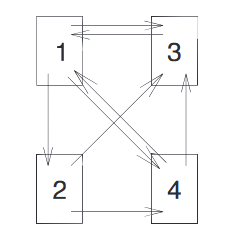

In [16]:
display(Image(filename="Graphs/Graph1.png"))

### Analysis of Graph 1 (Figure 2.1)
**Convergence:** The power iteration method converged in **19 iterations** to a residual norm $< 10^{-6}$.

**Spectral Interpretation:**
The ranking vector $x$ represents the **stationary distribution** of the random walk defined by the Google Matrix $M$.
* **Dominant Eigenvector:** Node 1 achieves the highest score ($x_1 \approx 0.368$). This high **eigenvector centrality** is not merely a function of in-degree (number of links) but of the quality of those links. Specifically, Node 1 receives a directed edge from Node 3 ($x_3 \approx 0.288$), effectively absorbing a significant portion of the probability mass circulating in the network.
* **Flow of Authority:** The hierarchy $x_1 > x_3 > x_4 > x_2$ illustrates the flow of importance: Node 3 acts as a key "hub" that transfers authority to Node 1. Node 2, despite being part of the strongly connected component, acts largely as a tributary, passing its mass forward without receiving high-value backlinks in return.

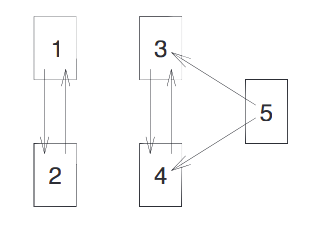

In [17]:
display(Image(filename="Graphs/Graph2.png"))

### Analysis of Graph 2 (Figure 2.2)

The numerical results reveal exact structural equivalences within the graph, highlighting specific connectivity patterns:

* **Symmetry Groups:**
    The ranking identifies two distinct equivalence classes:
    * **Group A ($\{3, 4\}$):** $x_3 = x_4 = 0.285$
    * **Group B ($\{1, 2\}$):** $x_1 = x_2 = 0.200$

    This implies that Nodes 3 and 4 are topologically interchangeable (they likely receive the same number of links from the same sources and point to the same targets). The same logic applies to Nodes 1 and 2. The significantly higher score of Group A suggests these nodes function as the central "authorities" within this small network.

* **Node 5: The "Pure Source" Node:**
    Node 5 has a score of exactly **0.030**. Given the parameters $N=5$ and $m=0.15$, we can mathematically isolate the origin of this value using the PageRank formula:

    $$x_5 = \underbrace{(1-m) \sum_{j \to 5} x_j}_{\text{Link Inflow}} + \underbrace{\frac{m}{N}}_{\text{Teleportation}}$$

    Since the are not **link inflow**, the importance score is  $\frac{m}{N} = \frac{0.15}{5} = 0.03$.

    Node 5 has an **In-Degree of 0**. It is a "Source" node that points to others but receives no endorsements itself. It appears in the ranking solely due to the random jump mechanism; without the damping factor $m$, its score would be 0.

### Analysis of Hollins University Dataset
**Convergence:** Convergence required **58 iterations**, significantly more than the previous examples. This indicates a smaller **spectral gap** $(1 - |\lambda_2|)$, typical of large, sparse matrices representing real-world web structures.

**Structural Insights:**

1.  **Dangling Nodes Handling (Mass Redistribution):**
    The dataset contains **3189 dangling nodes** ($\approx 53\%$ of the graph). In the raw link matrix $A$, these nodes correspond to columns of zeros. Instead of simple re-normalization (which would bias the result towards existing strong pages), our algorithm implements the **standard mass redistribution** method.
    At each iteration, the probability mass $w$ that "enters" these dead ends is captured and redistributed uniformly to all nodes in the graph. This correctly models the behavior of a random surfer who, upon reaching a dead end, jumps to a random page rather than disappearing.

2.  **Cluster Analysis:**
    * **Global Maxima:** The homepage (`www.hollins.edu`) and top-level directories (Admissions, About) dominate the ranking. This is consistent with a "nested" website topology where most leaf nodes point back to the root, concentrating the steady-state probability at the top of the hierarchy.
    * **Local Traps (Slide Galleries):** We observe a cluster of high-ranking pages related to specific academic slides (e.g., "Sculpture/sld001.htm"). These likely form a **tightly knit strongly connected component** (a clique of pages linking to Next/Previous). In a random walk, the surfer gets "trapped" in this subgraph for a long time before teleporting out, artificially inflating the local PageRank scores.

# Exercise 12: Dangling Nodes and Robustness

**Problem Statement:**
Add a sixth page that links to every page of the web in the previous exercise, but to which no other page links. Rank the pages using the raw link matrix $A$, then using the Google matrix $M$ with $m=0.15$, and compare the results.

This exercise demonstrates the failure of the basic eigenvector method when dangling nodes are present and how the damping factor $m$ resolves this issue.

In [18]:
def get_eigenpairs(A, k=None):
    # Helper function: Use Scipy for large matrices, Numpy for small ones.
    # Scipy eigs requires k < N-1, which fails on very small graphs (e.g., 4 nodes).
    n = A.shape[0]
    if k is None: k = min(n - 2, 6)
    if k < 1: k = 1

    if n < 10 or k >= n-1:
        # Fallback to dense for small graphs or when many eigenvalues are needed
        vals, vecs = np.linalg.eig(A.toarray())
    else:
        try:
            vals, vecs = splinalg.eigs(A, k=k, which='LM')
        except:
            vals, vecs = np.linalg.eig(A.toarray())
    return vals, vecs

In [19]:
print("Exercise 12 Analysis:")
filename = "Graphs/exercise12_graph.dat"

# 1. Analyze using the raw Link Matrix A
A, labels = read_dat(filename)

if A is not None:
    print(f"--- Ranking using Matrix A (Raw Link Structure) ---")
    eigenvalues, eigenvectors = get_eigenpairs(A)
    
    # Check for eigenvalue 1
    idx_list = np.where(np.isclose(eigenvalues, 1))[0]
    
    if len(idx_list) > 0:
        idx = idx_list[0]
        x_raw = np.real(eigenvectors[:, idx])
        
        # Normalize
        importance_score = x_raw / x_raw.sum()
        
        sorted_indices = np.argsort(importance_score)[::-1]
        for rank, idx in enumerate(sorted_indices, 1):
            node_label = labels[idx + 1]
            score = importance_score[idx]
            print(f"  {rank}. {node_label:20s}: {score:.6f}")
    else:
        print("Eigenvalue 1 not found for Matrix A (expected behavior for dangling nodes).")

    print("\n" + "-"*50 + "\n")

    # 2. Analyze using the Google Matrix M (m=0.15)
    print(f"--- Ranking using Matrix M (m=0.15) ---")
    analyze_graph(filename, m=0.15)

Exercise 12 Analysis:
--- Ranking using Matrix A (Raw Link Structure) ---
  1. Node3               : 0.367347
  2. Node1               : 0.244898
  3. Node5               : 0.183673
  4. Node4               : 0.122449
  5. Node2               : 0.081633
  6. Node6               : -0.000000

--------------------------------------------------

--- Ranking using Matrix M (m=0.15) ---
Analyzing Graphs/exercise12_graph.dat ...
  - No dangling nodes detected.
  Converged in 28 iterations
  PageRank scores (Top results):
  ----------------------------------------
  1. Node3               : 0.340172
  2. Node1               : 0.231212
  3. Node5               : 0.173823
  4. Node4               : 0.135033
  5. Node2               : 0.094760
  6. Node6               : 0.025000




### Discussion of Results

The comparison between the raw link matrix $A$ and the Google Matrix $M$ highlights the necessity of the damping factor for ensuring a complete ranking of the network.

1. **Matrix A (Connectivity Issue):**
   The raw model correctly identifies the topological disconnection of **Node 6**. Since the node has **no incoming links** (orphan node), it receives no endorsement from the rest of the network, resulting in a null score ($x_6 = 0.00$).

2. **Matrix M (Regularization):**
   The Google Matrix model (with $m=0.15$) solves the reachability problem via the teleportation mechanism.
   * **Minimum Score Guarantee:** Node 6 is assigned a score of exactly $0.025$. This corresponds to the uniform redistribution of the damping probability:
     $$\frac{m}{n} = \frac{0.15}{6} = 0.025$$
     This confirms that Node 6 relies entirely on the random surfer "jumping" to it (teleportation) rather than incoming links.
   * **Preservation of Hierarchy:** The relative ranking of the top nodes remains stable (Node 3 > Node 1 > Node 5), maintaining the logical structure of the dominant component of the web graph while integrating isolated nodes into the global system.


# Exercise 15: Convergence Rate Analysis

**Problem Statement:**
Consider an $n \times n$ positive column-stochastic matrix $M$ that is diagonalizable. Let $x_0$ be any probability vector. Using the spectral decomposition, evaluate the limit:

$$
\lim_{k\to\infty} \frac{||M^k x_0 - q||_1}{||M^{k-1} x_0 - q||_1}
$$

where $q$ is the steady-state vector.

## Proof

### Hypotheses:
1. $M$ is a positive, column-stochastic matrix ($M_{ij} > 0$).
2. $M$ is diagonalizable.
3. The eigenvalues are ordered such that $\lambda_1 = 1 > |\lambda_2| \ge |\lambda_3| \ge \dots \ge |\lambda_n|$.
4. $\{\mathbf{v}_1, \mathbf{v}_2, \dots, \mathbf{v}_n\}$ is a basis of eigenvectors, where $\mathbf{v}_1 = \mathbf{q}$ is the unique steady-state vector associated with $\lambda_1 = 1$.
5. $x_0$ is the initial probability vector ($\sum (x_0)_i = 1$).

### Part 1: Spectral Expansion
Since the eigenvectors form a basis for $\mathbb{R}^n$, we can write the initial vector $x_0$ as a linear combination:

$$
x_0 = c_1 \mathbf{v}_1 + \sum_{j=2}^{n} c_j \mathbf{v}_j
$$

Applying the matrix $M$ iteratively $k$ times, and noting that $M^k \mathbf{v}_1 = 1^k \mathbf{q} = \mathbf{q}$ and $M^k \mathbf{v}_j = \lambda_j^k \mathbf{v}_j$:

$$
M^k x_0 = c_1 \mathbf{q} + \sum_{j=2}^{n} c_j \lambda_j^k \mathbf{v}_j
$$

### Part 2: Determining the first coefficient ($c_1=1$)
Let $\mathbf{e} = [1, 1, \dots, 1]^T$. Since $M$ is column-stochastic, we have $\mathbf{e}^T M = \mathbf{e}^T$.
For any eigenvector $\mathbf{v}_j$ with $\lambda_j \neq 1$ (i.e., $j \ge 2$):

$$
\mathbf{e}^T M \mathbf{v}_j = \lambda_j (\mathbf{e}^T \mathbf{v}_j) \implies \mathbf{e}^T \mathbf{v}_j = \lambda_j (\mathbf{e}^T \mathbf{v}_j)
$$

$$
(1 - \lambda_j)(\mathbf{e}^T \mathbf{v}_j) = 0
$$

Since $\lambda_j \neq 1$, it must be that $\mathbf{e}^T \mathbf{v}_j = 0$. In other words, the sum of components of any non-principal eigenvector is zero.

Now, check the sum of components for $x_0$:

$$
\mathbf{e}^T x_0 = c_1 (\mathbf{e}^T \mathbf{q}) + \sum_{j=2}^n c_j (\mathbf{e}^T \mathbf{v}_j)
$$

Since $x_0$ and $\mathbf{q}$ are probability vectors, their sums are 1. Since $\mathbf{e}^T \mathbf{v}_j = 0$ for $j \ge 2$:

$$
1 = c_1(1) + 0 \implies c_1 = 1
$$

### Part 3: Bounding eigenvalues
Since $M$ is a positive matrix ($M_{ij} > 0$), it is *primitive*. By the **Perron-Frobenius Theorem**, the spectral radius is 1, and 1 is the unique eigenvalue on the spectral circle. Therefore:

$$
|\lambda_j| < 1 \quad \text{for all } j = 2, \dots, n.
$$

This ensures that $\lim_{k \to \infty} \lambda_j^k = 0$.

### Part 4: Evaluation of the Limit
We evaluate the ratio of the errors. The error vector at step $k$ is:

$$
M^k x_0 - \mathbf{q} = \left( \mathbf{q} + \sum_{j=2}^{n} c_j \lambda_j^k \mathbf{v}_j \right) - \mathbf{q} = \sum_{j=2}^{n} c_j \lambda_j^k \mathbf{v}_j
$$

For sufficiently large $k$, the sum is asymptotically dominated by the term associated with the largest eigenvalue magnitude less than 1, which is $|\lambda_2|$. We assume the generic case where the initial vector $x_0$ has a non-zero component along $\mathbf{v}_2$ (i.e., $c_2 \neq 0$).

$$
M^k x_0 - \mathbf{q} \approx c_2 \lambda_2^k \mathbf{v}_2 \quad \text{as } k \to \infty
$$

$$
M^{k-1} x_0 - \mathbf{q} \approx c_2 \lambda_2^{k-1} \mathbf{v}_2 \quad \text{as } k \to \infty
$$

Substituting these approximations into the limit expression:

$$

\lim_{k\to\infty} \frac{||M^k x_0 - q||_1}{||M^{k-1} x_0 - q||_1}=\lim_{k\to\infty} \frac{||c_2 \lambda_2^k \mathbf{v}_2||_1}{||c_2 \lambda_2^{k-1} \mathbf{v}_2||_1} = \lim_{k\to\infty} \frac{|c_2| |\lambda_2|^k ||\mathbf{v}_2||_1}{|c_2| |\lambda_2|^{k-1} ||\mathbf{v}_2||_1} = \frac{|\lambda_2|^k}{|\lambda_2|^{k-1}} = |\lambda_2|
$$

### Conclusion
The limit evaluates to $|\lambda_2|$. This result demonstrates that the asymptotic convergence rate of the Power Method is entirely governed by the **subdominant eigenvalue** $\lambda_2$.

Specifically:
* The error $||\text{error}_k||_1$ decreases by a factor of approximately $|\lambda_2|$ at each iteration.
* The speed of convergence depends on the **Spectral Gap** ($1 - |\lambda_2|$). A larger gap (smaller $|\lambda_2|$) implies fewer iterations are needed to reach a desired tolerance.
* In the context of the PageRank algorithm, this $\lambda_2$ corresponds exactly to the damping factor $\alpha$ (typically $0.85$). This explains why Google's computation is efficient: the error reduces by roughly $0.85$ per step, ensuring convergence in a predictable number of iterations regardless of the web's size.